# Generate an observation map to map model output to observational data

In [146]:
using Pkg; Pkg.activate(".")
using Revise 
using ClimaAnalysis
import ClimaAtmos as CA
using NCDatasets
import YAML
using Plots
import Glob
using CairoMakie
import ClimaAnalysis.Visualize as viz
import ClimaAnalysis.Utils: kwargs
import JLD2

import Interpolations
using Statistics


  Activating project at `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/reanalysis_forcing`


In [ ]:
# load sample model data
function get_z_grid(atmos_config; z_max = nothing)
    params = CA.create_parameter_set(atmos_config)
    spaces =
        CA.get_spaces(atmos_config.parsed_args, params, atmos_config.comms_ctx)
    coord = CA.Fields.coordinate_field(spaces.center_space)
    z_vec = convert(Vector{Float64}, parent(coord.z)[:])
    if !isnothing(z_max)
        z_vec = filter(x -> x <= z_max, z_vec)
    end
    return z_vec
end

config = CA.AtmosConfig("prognostic_edmfx_gcmdriven_column.yml")
get_z_grid(config)


[ Info: Loading yaml file /Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
[ Info: Loading yaml file prognostic_edmfx_gcmdriven_column.yml
┌ Warning: Failed to convert `config_dict["truncation"] = 40000` to default type String, keeping original value
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/yaml_helper.jl:81
[ Info: Running on CPUSingleThreaded.
[ Info: Setting up single-process ClimaAtmos run
[ Info: Running ClimaCore in unthreaded mode.
┌ Info: Making AtmosConfig with config files: 
│    /Users/julianschmitt/Documents/Research/loss/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
└    prognostic_edmfx_gcmdriven_column.yml
┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not compatibl

61-element Vector{Float64}:
    15.0
    46.275184631347656
    80.2084732055664
   117.02432250976562
   156.96588134765625
   200.29647827148438
   247.3013458251953
   298.2891845703125
   353.59423828125
   413.578125
     ⋮
 21730.02734375
 23300.2109375
 24958.203125
 26705.52734375
 28543.25390625
 30471.9140625
 32491.46875
 34601.21875
 36799.7890625

┌ Info: Topography
└   topography = "NoWarp"
┌ Warning: perturb_initstate flag is ignored for single column configuration
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:200
┌ Warning: Bubble correction not compatible with single column configuration. It will be switched off.
└ @ ClimaAtmos ~/Documents/Research/loss/ClimaAtmos.jl/src/solver/type_getters.jl:211
[ Info: Truncating grid to 62 elements below 40000 meters.
┌ Info: Resolution stats: 
│   Nq = 1
│   h_elem = 6
│   z_elem = 73
│   ncols = 1
└   ndofs_total = 73


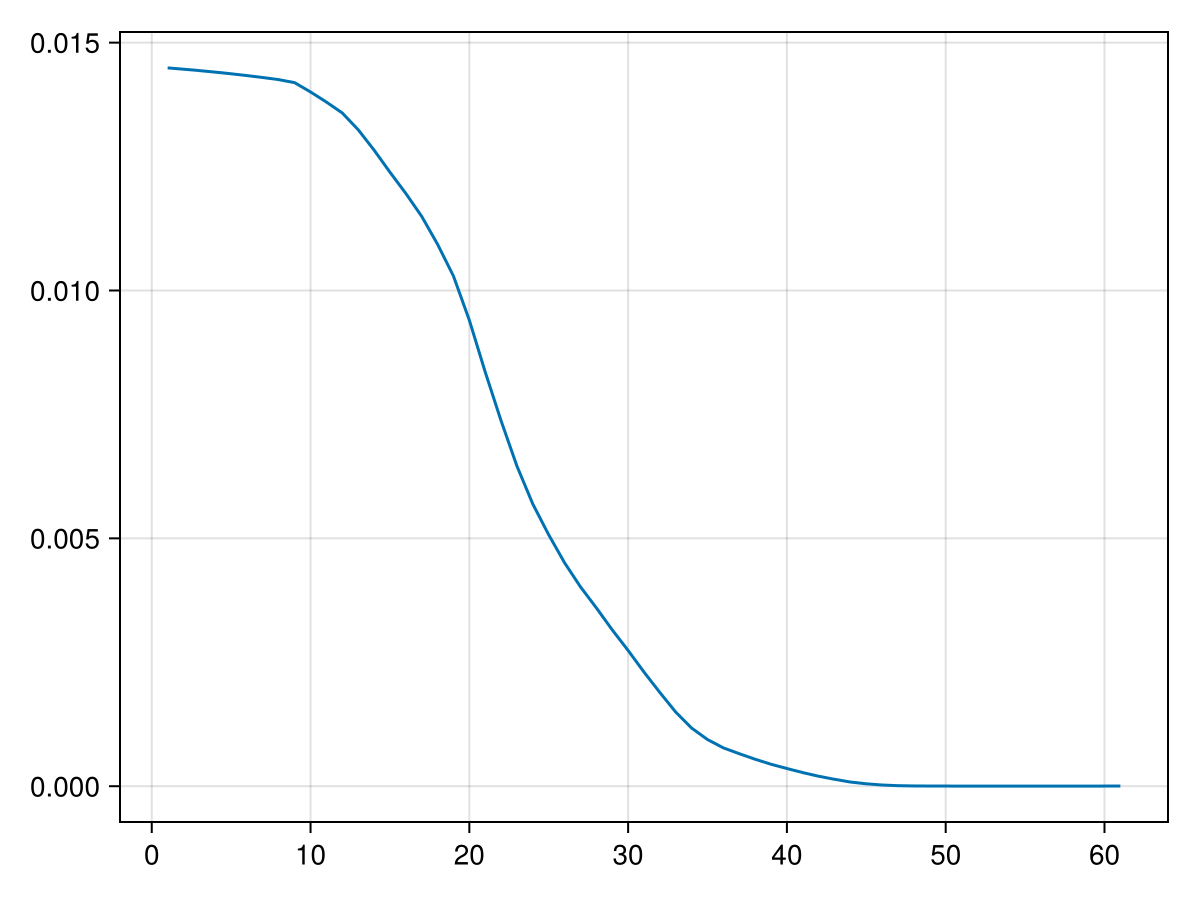

In [124]:
filename = "era5_cfsite_obs_data.nc"
ds = NCDataset(filename, "r")
# path = joinpath("/", "site23", "ta")
# data_var = ds[path]
# data_var

ds.group["site23"]["ta"] 
month = 7   
month_idx = findfirst(==(month), ds.group["site23"]["month"][:])
lines(ds.group["site23"]["clw"][:, month_idx])
lines(ds.group["site23"]["clw"][:, 1])


function nc_fetch(filename::String, month::Integer, site::String, var_name::String)
    NCDataset(filename, "r") do ds
        # carefully select the correct month index
        month_idx = findfirst(==(month), ds.group[site]["month"][:])
        return ds.group[site][var_name][:, month_idx]
    end
end

# get height 
function get_height(filename::String, month::Integer, site::String)
    NCDataset(filename, "r") do ds
        month_idx = findfirst(==(month), ds.group[site]["month"][:])
        # divide by gravity 
        return ds.group[site]["z"][:, month_idx] ./ 9.807
    end
end

function vertical_interpolation(
    month::Integer,
    site::String,
    var_name::String,
    filename::String,
    z_scm::Vector{FT};
) where {FT <: AbstractFloat}
    # get height of ERA5 data 
    z_ref =get_height(filename, month, site)
    # get ERA5 variable
    var_ = nc_fetch(filename, month, site, var_name)
    if ndims(var_) == 2
        # Create interpolant
        nodes = (z_ref, 1:size(var_, 2))
        var_itp = Interpolations.extrapolate(
            Interpolations.interpolate(
                nodes,
                var_,
                (
                    Interpolations.Gridded(Interpolations.Linear()),
                    Interpolations.NoInterp(),
                ),
            ),
            Interpolations.Line(),
        )
        # Return interpolated vector
        return var_itp(z_scm, 1:size(var_, 2))
    elseif ndims(var_) == 1
        # Create interpolant
        nodes = (z_ref,)
        if var_name in ["clw"]
            # prevent from going negative at the bottom boundary
            var_itp = Interpolations.LinearInterpolation(nodes,var_;
                extrapolation_bc = Interpolations.Flat(),
            )
        else 
            var_itp = Interpolations.LinearInterpolation(nodes,var_;
                extrapolation_bc = Interpolations.Line(),
            )
        end
        # Return interpolated vector
        return var_itp(z_scm)
    end
end

# test 
z_scm = get_z_grid(config)


t = vertical_interpolation(7, "site23", "hus", filename, z_scm)


# test 
# z_ref = get_height(filename)
lines(t)

In [ ]:
# get norm factors dict
mean_factors = Dict{String, Float64}()
std_factors = Dict{String, Float64}()


for var_name in ["ta", "clw", "hus"]
    ar = []
    for site in 2:23
        for month in 1:12
            var_ = nc_fetch(filename, month, "site$site", var_name)
            # append to ar
            push!(ar, var_)
            
        end
    end
    if var_name == "clw" # take log transform
        ar = log10.(hcat(ar...) .+ 1e-12)
    end
    var_std = std(hcat(ar...))
    var_mean = mean(hcat(ar...))
    println("var_name: $var_name, mean: $var_mean, std: $var_std")
    mean_factors[var_name] = var_mean
    std_factors[var_name] = var_std
end
mean_factors, std_factors

var_name: ta, mean: 252.80049, std: 31.169933
var_name: clw, mean: -9.32233596518829, std: 3.1089667405434276
var_name: hus, mean: 0.0020396786, std: 0.0034636273


(Dict("clw" => -9.32233596518829, "hus" => 0.0020396786276251078, "ta" => 252.8004913330078), Dict("clw" => 3.1089667405434276, "hus" => 0.003463627304881811, "ta" => 31.169933319091797))

In [148]:
norm_factors_dict = Dict(
    "ta" => (mean_factors["ta"], std_factors["ta"]),
    "clw" => (mean_factors["clw"], std_factors["clw"]),
    "hus" => (mean_factors["hus"], std_factors["hus"]),
)
# save norm factors dict
# JLD2.save("norm_factors_dict.jld2", "norm_factors_dict", norm_factors_dict)
typeof(norm_factors_dict)

Dict{String, Tuple{Float64, Float64}}

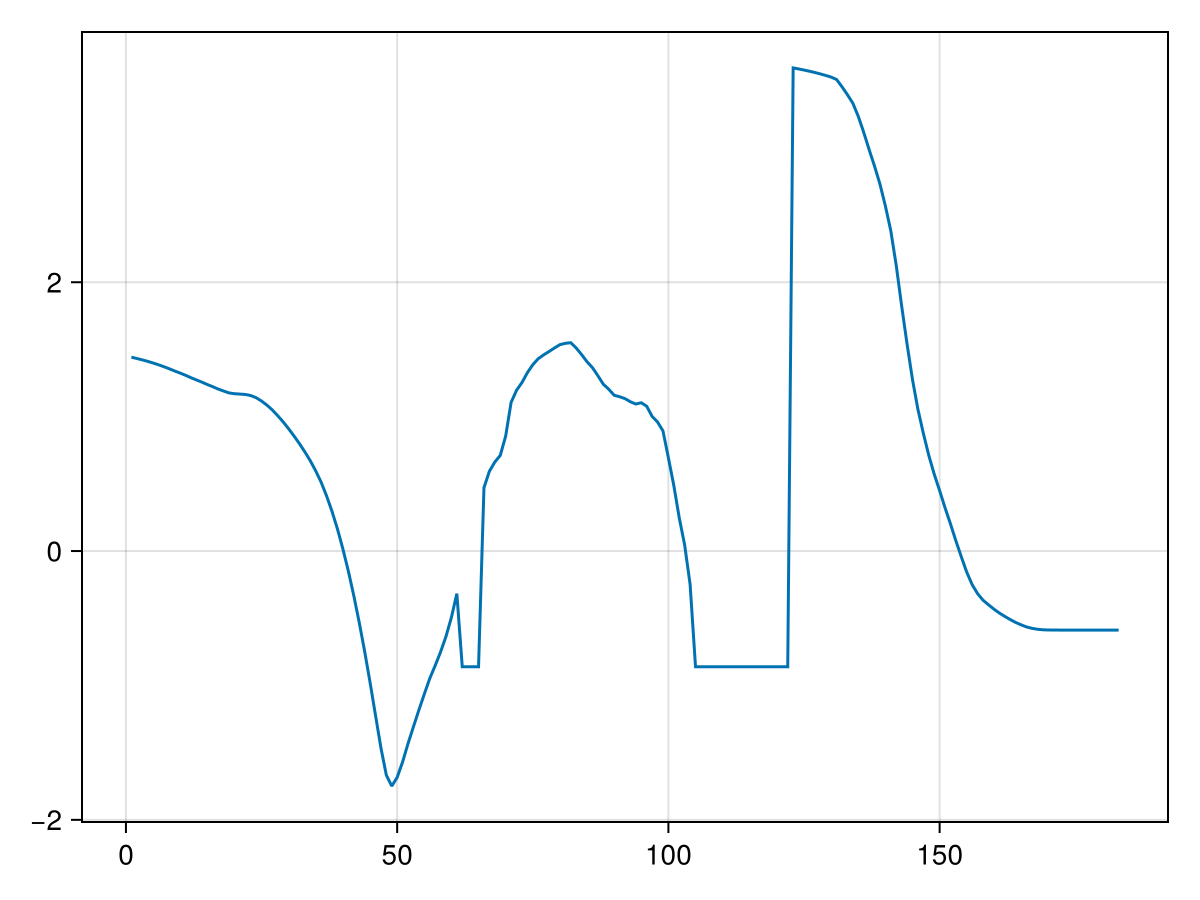

In [150]:
function get_obs(
    filename::String,
    month::Integer,
    site::String,
    y_names::Vector{String},
    normalize::Bool,
    norm_factors_dict::Dict{String, Tuple{Float64, Float64}},
    z_scm::Vector{FT},
    log_vars::Vector{String} = ["clw"],
) where {FT <: AbstractFloat}
    y = []
    for var_name in y_names
        var_ = vertical_interpolation(month, site, var_name, filename, z_scm)
        if var_name in log_vars
            var_ = log10.(var_ .+ 1e-12)
        end
        if normalize
            # normalize
            var_ = (var_ .- norm_factors_dict[var_name][1]) ./ norm_factors_dict[var_name][2]
            push!(y, var_)
        else
            push!(y, var_)
        end
    end
    return vcat(y...)
end

lines(get_obs(filename, 7, "site23", ["ta", "clw", "hus"], true, mean_factors, std_factors, z_scm))

In [ ]:
function process_profile_variable(
    simdir,
    y_name;
    reduction,
    t_start,
    t_end,
    z_max = nothing,
    norm_factors_dict = nothing,
    log_vars = [],
)

    var_i = get(simdir; short_name = y_name, reduction)

    # subset vertical coordinate
    if !isnothing(z_max)
        z_window = filter(x -> x <= z_max, var_i.dims["z"])
        var_i = window(var_i, "z", right = maximum(z_window))
    end
    sim_t_end = var_i.dims["time"][end]
    println("sim time: $(sim_t_end/86400.) days")

    # if sim_t_end < 0.95 * t_end
    #     throw(ErrorException("Simulation failed."))
    # end

    # take time-mean
    var_i_ave =
        average_time(window(var_i, "time", left = t_start, right = sim_t_end))
    y_var_i = slice(var_i_ave, x = 1, y = 1).data

    if y_name in log_vars
        y_var_i = log10.(y_var_i .+ 1e-12)
    end

    # normalize
    if !isnothing(norm_factors_dict)
        y_μ, y_σ = norm_factors_dict[y_name]
        y_var_i = (y_var_i .- y_μ) ./ y_σ
    end

    return y_var_i

end


function process_member_data(
    member_path;
    #eki;
    y_names,
    reduction = "inst",
    t_start,
    t_end,
    z_max = nothing,
    norm_factors_dict = nothing,
    log_vars = [],
)
    #forcing_file_indices = EKP.get_current_minibatch(eki)
    g = Float64[]
    # for i in forcing_file_indices
    simdir = SimDir(member_path)#SimDir(joinpath(member_path, "config_$i", "output_0000"))
    for (i, y_name) in enumerate(y_names)
        y_var_i = process_profile_variable(
            simdir,
            y_name;
            reduction,
            t_start,
            t_end,
            z_max,
            norm_factors_dict,
            log_vars,
        )
        append!(g, y_var_i)
    end
    # end

    return g
end

# model_output = process_profile_variable(SimDir("output/month_7/site23/output_active"),
#     "hus"; reduction = "inst", t_start = 86400., t_end = 2*86400., z_max = nothing, norm_factors_dict = norm_factors_dict, log_vars = ["clw"])

model_output = process_member_data("output/month_7/site23/output_active", 
                                y_names = ["ta", "clw", "hus"], 
                                reduction = "inst", 
                                t_start = 0., 
                                t_end = 12*86400., 
                                z_max = nothing, 
                                norm_factors_dict = norm_factors_dict, 
                                log_vars = ["clw"])


sim time: 0.9297453703703704 days
sim time: 0.9297453703703704 days
sim time: 0.9297453703703704 days


183-element Vector{Float64}:
  1.4671873529481236
  1.4585499884897963
  1.4487005341199517
  1.4378357831117838
  1.4258147492397208
  1.4126932395513847
  1.3985133541002455
  1.383088090323217
  1.3663087713380877
  1.3481851878549669
  ⋮
 -0.5881507974237322
 -0.5881303881123083
 -0.5881103669663609
 -0.5880903842890366
 -0.588074523334318
 -0.5880580061810365
 -0.5880388256992343
 -0.5880158649859152
 -0.5879888537760251

sim time: 12.499768518518518 days
sim time: 12.499768518518518 days
sim time: 12.499768518518518 days


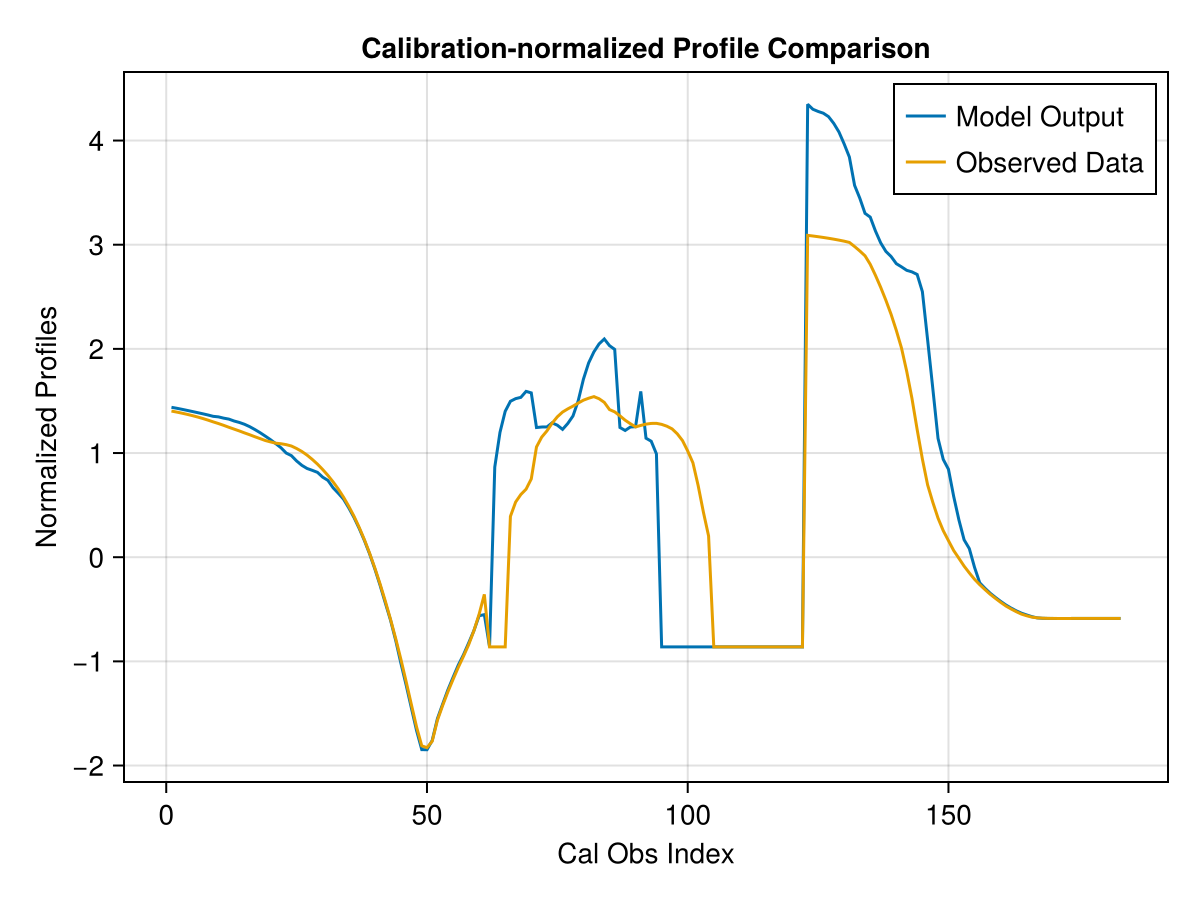

In [198]:
# plot model output and obs on same plot with different colored lines labeled
fig = Figure()
ax = Axis(fig[1, 1], title = "Calibration-normalized Profile Comparison", xlabel = "Cal Obs Index", ylabel = "Normalized Profiles")

# Plot the model output
month = 1
site = 23
model_output = process_member_data("output/month_$month/site$site/output_active", 
                                #nothing,
                                y_names = ["ta", "clw", "hus"], 
                                reduction = "inst", 
                                t_start = 0*86400., 
                                t_end = 12*86400., 
                                z_max = nothing, 
                                norm_factors_dict = norm_factors_dict, 
                                log_vars = ["clw"])
lines!(ax, 1:length(model_output), model_output, label = "Model Output")

# Get observed data and plot it
obs_data = get_obs(filename, month, "site$site", ["ta", "clw", "hus"], true, mean_factors, std_factors, z_scm)
lines!(ax, 1:length(obs_data), obs_data, label = "Observed Data")

# Add a legend
axislegend(ax)

# Display the figure
fig